In [1]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git
!git clone https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

fatal: destination path 'imagenet-sample-images' already exists and is not an empty directory.
fatal: destination path '942d3a0ac09ec9e5eb3a' already exists and is not an empty directory.


In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.models import vgg19, resnet18, resnet152
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import cv2

import warnings
warnings.filterwarnings("ignore")
txt = open('./942d3a0ac09ec9e5eb3a/imagenet1000_clsidx_to_labels.txt', "r").readlines()

lines_str = ''.join(txt)
import ast

# Convert the string to a dictionary
imagenet_class = ast.literal_eval(lines_str)


from PIL.Image import open

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

path_list = ['n02504458_African_elephant.JPEG', 
             'n02106662_German_shepherd.JPEG', 
             'n01534433_junco.JPEG',
             'n04447861_toilet_seat.JPEG',
             'n04456115_torch.JPEG']
image_list = list()
for dir in path_list:
    image = open(f'imagenet-sample-images/{dir}')
    image_list.append(image)

image_batch = torch.stack([transform(image) for image in image_list])
image_batch.shape

torch.Size([5, 3, 224, 224])

In [3]:
class GradCAM_model(nn.Module):
    def __init__(self, model):
        super().__init__()
        if model == 'resnet152':
            resnet = resnet152(pretrained='ResNet152_Weights.IMAGENET1K_V1')
            self.encoder = torch.nn.Sequential(*(list(resnet.children())[:-2]))
            self.pool = resnet.avgpool
            self.classifier = resnet.fc

        elif model == 'resnet18':
            resnet = resnet18(pretrained='ResNet18_Weights.IMAGENET1K_V1')
            self.encoder = torch.nn.Sequential(*(list(resnet.children())[:-2]))
            self.pool = resnet.avgpool
            self.classifier = resnet.fc
        
        elif model == 'vgg19':
            vgg = vgg19(pretrained='VGG19_Weights.IMAGENET1K_V1')
            self.encoder = vgg.features
            self.pool = vgg.avgpool
            self.classifier = vgg.classifier

        else:
            assert False, f'{model} is not available'
        
        self.gradients = None
    
    def featuremap_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.encoder(x)
        x.register_hook(self.featuremap_hook)
        x = self.pool(x)
        x = x.flatten(start_dim = 1)
        x = self.classifier(x)
        return x
    
    def get_featuremap(self, x):
        return self.encoder(x)


In [4]:
def GradCAM(model, image_batch):
    heatmap_list = list()
    pred_list = list()
    featuremap_list = list()
    model = GradCAM_model(model).cuda()
    model.eval()
    image_batch = image_batch.cuda()
    for image in tqdm(image_batch):
        image = image.unsqueeze(dim = 0)
        pred = model(image)
        pred.max(dim = 1)[0].backward()
        gradients = model.gradients.detach()
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        featuremap = model.get_featuremap(image).detach()
        assert gradients.shape == featuremap.shape, f'{gradients.shape} != {featuremap.shape}'
        for i in range(512):
            featuremap[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(featuremap, dim=1).squeeze()
        heatmap = torch.nn.functional.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap_list.append(heatmap.cpu())
        pred_list.append(imagenet_class[pred.argmax(dim = 1).item()])
        featuremap_list.append(featuremap.shape)
    return heatmap_list, pred_list, featuremap_list

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


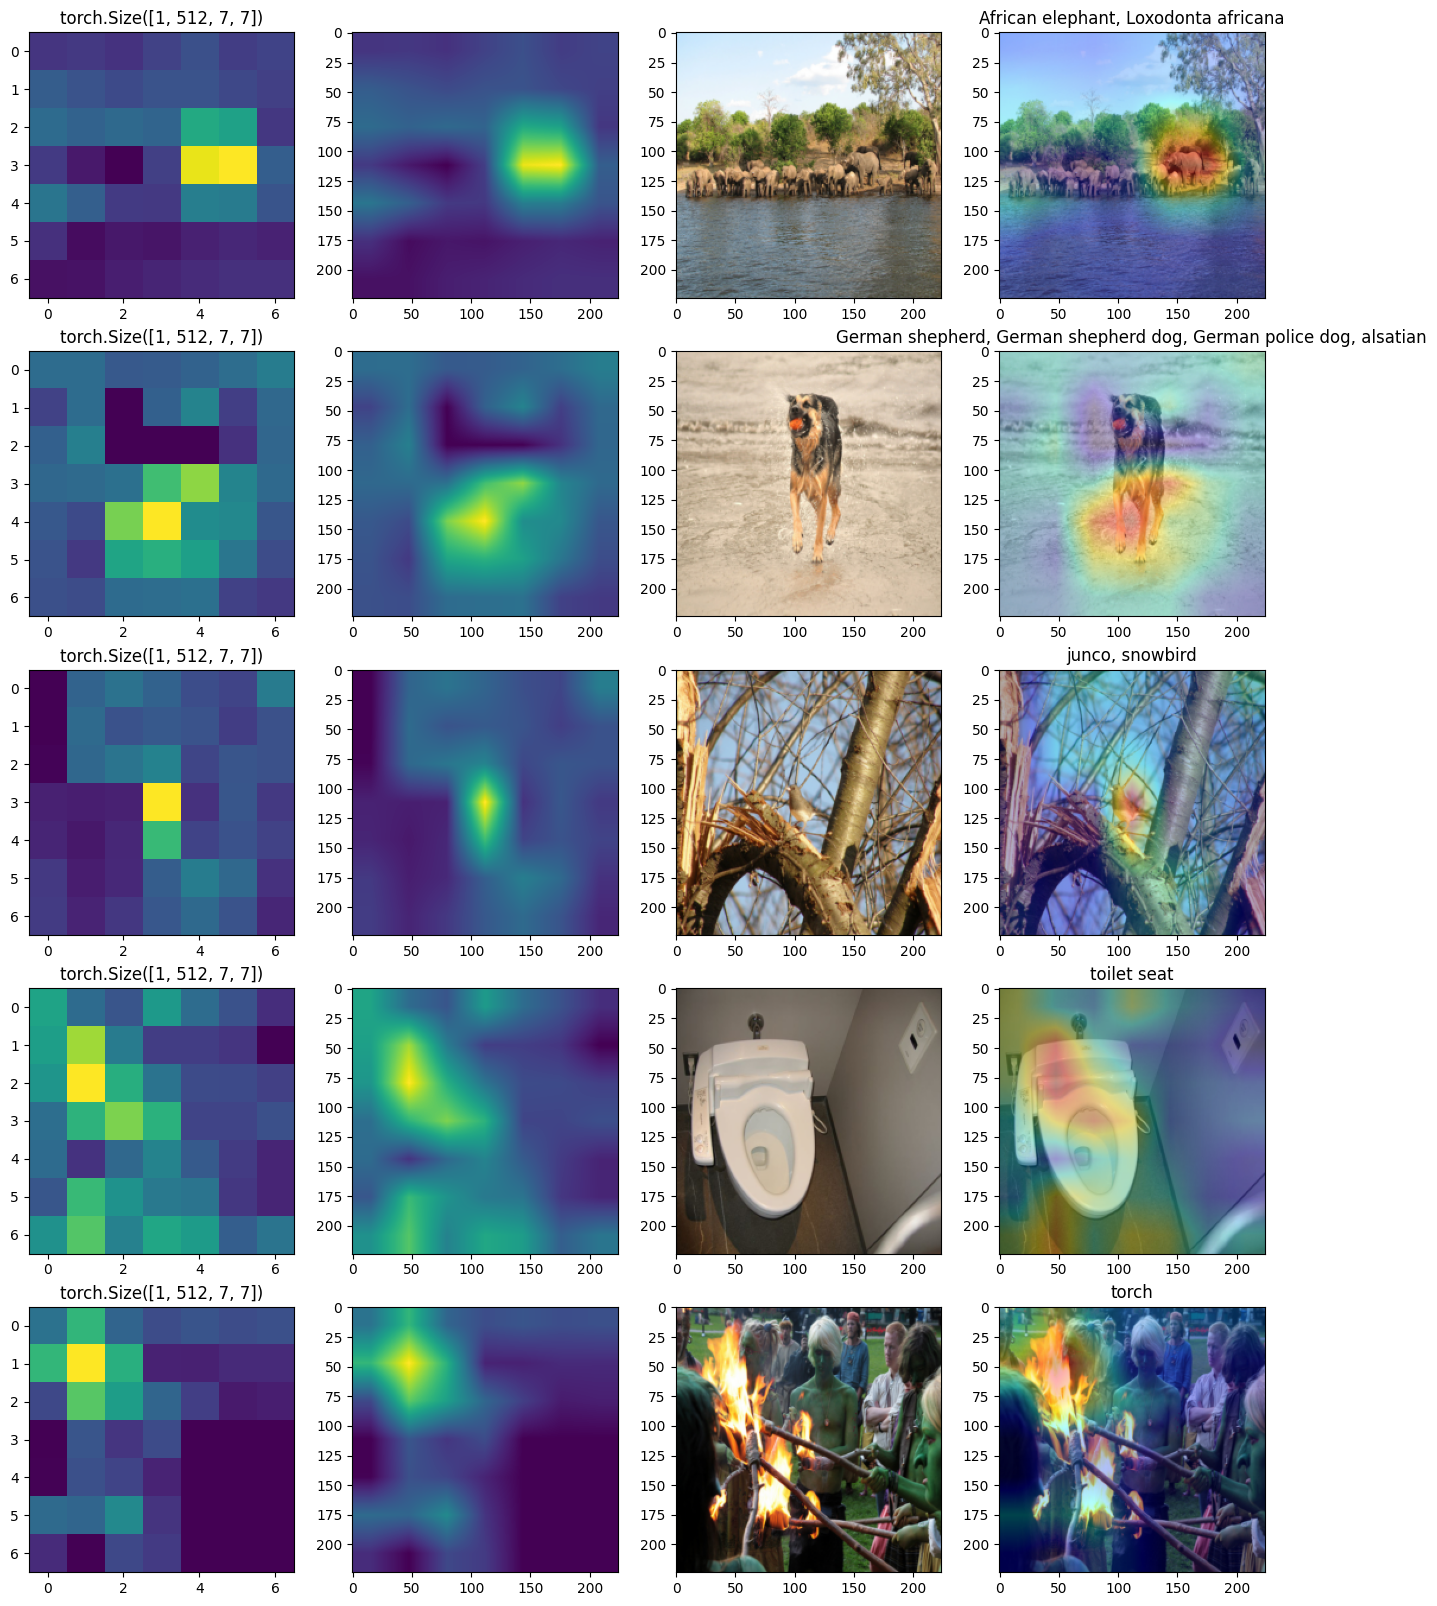

In [5]:
heatmap_list, pred_list, featuremap_list = GradCAM('vgg19', image_batch)
plt.figure(figsize = (4*4, 4*5))
for i, (image, heatmap) in enumerate(zip(image_batch, heatmap_list)):
    plt.subplot(5,4,1+4*i)
    plt.imshow(heatmap)
    plt.title( featuremap_list[i])
    
    plt.subplot(5,4,3+4*i)
    plt.imshow(
        image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    )
    
    plt.subplot(5,4,2+4*i)
    heatmap = cv2.resize(np.array(heatmap), (224, 224))
    plt.imshow(heatmap)
    
    plt.subplot(5,4,4+4*i)
    heatmap = np.uint8(255 * (1-heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.imshow(np.uint((image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
    plt.imshow(heatmap, alpha = 0.3)
    plt.title(pred_list[i])
    

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


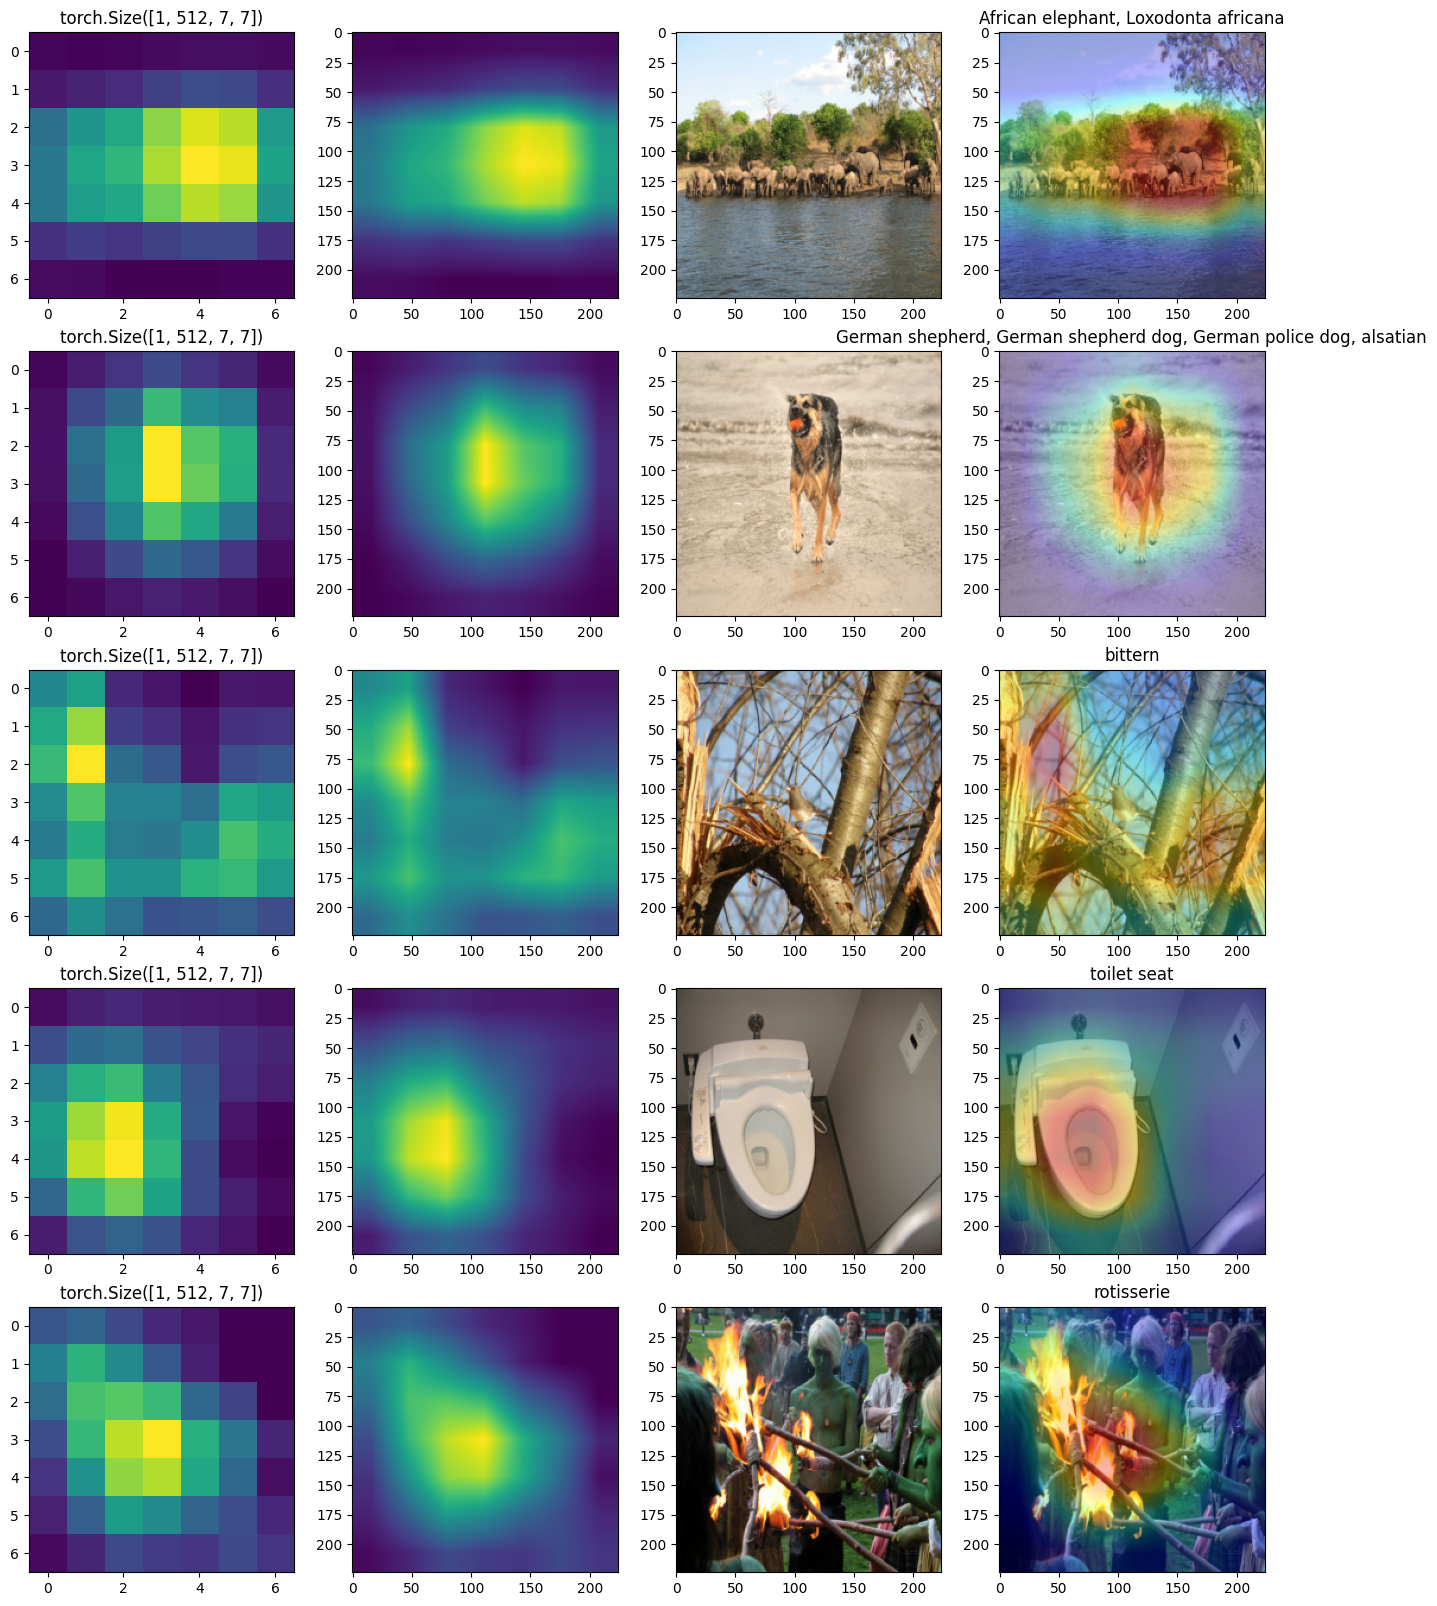

In [6]:
heatmap_list, pred_list, featuremap_list = GradCAM('resnet18', image_batch)
plt.figure(figsize = (4*4, 4*5))
for i, (image, heatmap) in enumerate(zip(image_batch, heatmap_list)):
    plt.subplot(5,4,1+4*i)
    plt.imshow(heatmap)
    plt.title( featuremap_list[i])
    
    plt.subplot(5,4,3+4*i)
    plt.imshow(
        image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    )
    
    plt.subplot(5,4,2+4*i)
    heatmap = cv2.resize(np.array(heatmap), (224, 224))
    plt.imshow(heatmap)
    
    plt.subplot(5,4,4+4*i)
    heatmap = np.uint8(255 * (1-heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.imshow(np.uint((image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
    plt.imshow(heatmap, alpha = 0.3)
    plt.title(pred_list[i])
    

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


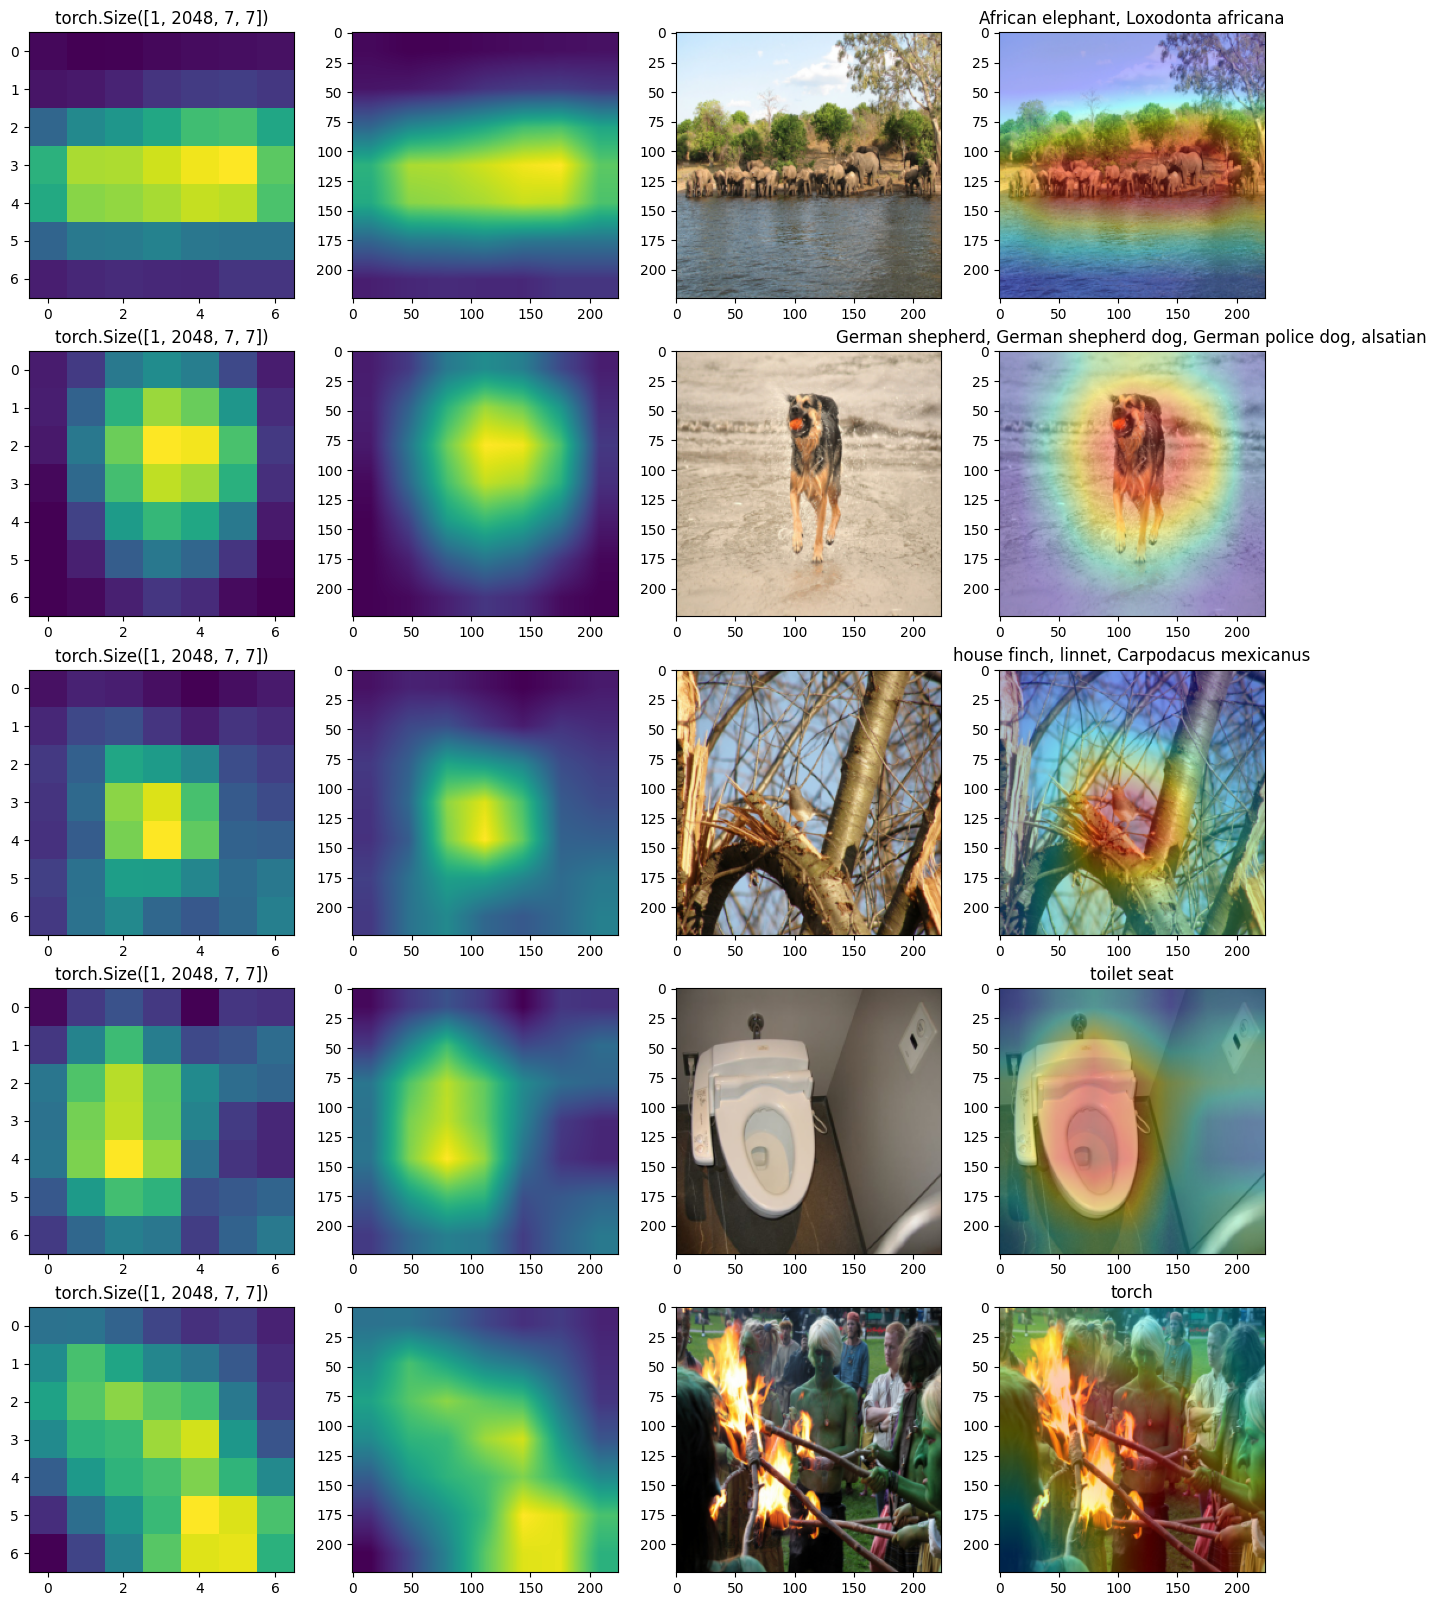

In [7]:
heatmap_list, pred_list, featuremap_list = GradCAM('resnet152', image_batch)
plt.figure(figsize = (4*4, 4*5))
for i, (image, heatmap) in enumerate(zip(image_batch, heatmap_list)):
    plt.subplot(5,4,1+4*i)
    plt.imshow(heatmap)
    plt.title( featuremap_list[i])
    
    plt.subplot(5,4,3+4*i)
    plt.imshow(
        image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    )
    
    plt.subplot(5,4,2+4*i)
    heatmap = cv2.resize(np.array(heatmap), (224, 224))
    plt.imshow(heatmap)
    
    plt.subplot(5,4,4+4*i)
    heatmap = np.uint8(255 * (1-heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.imshow(np.uint((image.numpy().transpose(1,2,0)*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])*255))
    plt.imshow(heatmap, alpha = 0.3)
    plt.title(pred_list[i])
    